In [76]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

## 1. Reading and Storing Data

### Data Pre-processing

In [14]:
if not os.path.isfile("../Data/CrunchbaseRatings.csv"): 
#This line: "os.path.isfile("../Data/CrunchbaseRatings.csv")" simply checks that is there a file with the name "CrunchbaseRatings.csv" in the 
#in the folder "/Data/". If the file is present then it return true else false
    startTime = datetime.now()
    data = open("../Data/CrunchbaseRatings.csv", mode = "w") #this line simply creates the file with the name "CrunchbaseRatings.csv" in 
    #write mode in the folder "Data".
#     files = ['../Data/combined_data_1.txt','../Data/combined_data_2.txt', '../Data/combined_data_3.txt', '../Data/combined_data_4.txt']
    files = ['../Data/combined_data_2.txt', '../Data/combined_data_4.txt']
    for file in files:
        print("Reading from file: "+str(file)+"...")
        with open(file) as f:  #you can think of this command "with open(file) as f" as similar to 'if' statement or a sort of 
            #loop statement. This command says that as long as this file is opened, perform the underneath operation.
            for line in f:
                line = line.strip() #line.strip() clears all the leading and trailing spaces from the string, as here each line
                #that I am reading from a file is a string.
                #Note first line consist of a startup id followed by a semi-colon, then second line contains investorID,rating,date
                #then third line agains contains investorID,rating,date which belong to that startup ID and so on.
                if line.endswith(":"):
                    startupID = line.replace(":", "") #this will remove the trailing semi-colon and return us the leading startup ID.
                else:
                    row = [] 
                    row = [x for x in line.split(",")] #startupID, rating and date are separated by comma
                    row.insert(0, startupID)
                    data.write(",".join(row))
                    data.write("\n")
        print("Reading of file: "+str(file)+" is completed\n")
    data.close()
    print("Total time taken for execution of this code = "+str(datetime.now() - startTime))

Reading from file: ../Data/combined_data_2.txt...
Reading of file: ../Data/combined_data_2.txt is completed

Reading from file: ../Data/combined_data_4.txt...
Reading of file: ../Data/combined_data_4.txt is completed

Total time taken for execution of this code = 0:03:48.924208


In [15]:
# creating data frame from our output csv file.
if not os.path.isfile("../Data/CrunchbaseData.pkl"):
    startTime = datetime.now()
    Final_Data = pd.read_csv("../Data/CrunchbaseRatings.csv", sep=",", names = ["startupID","investorID", "Ratings", "Date"])
    Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
    Final_Data.sort_values(by = "Date", inplace = True)
    print("Time taken for execution of above code = "+str(datetime.now() - startTime))

Time taken for execution of above code = 0:01:11.269949


In [16]:
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile("../Data/CrunchbaseData.pkl"):
    Final_Data.to_pickle("../Data/CrunchbaseData.pkl")
else:
    Final_Data = pd.read_pickle("../Data/CrunchbaseData.pkl")

In [18]:
Final_Data.describe()["Ratings"]

count    5.382511e+07
mean     3.606058e+00
std      1.082326e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

### Checking for NaN

In [ ]:
print("Number of NaN values = "+str(Final_Data.isnull().sum()))

### Removing Duplicates

In [20]:
duplicates = Final_Data.duplicated(["startupID","investorID", "Ratings"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


### Basic Statistics

In [ ]:
print("Total Data:")
print("Total number of startup ratings = "+str(Final_Data.shape[0]))
print("Number of unique investors = "+str(len(np.unique(Final_Data["investorID"]))))
print("Number of unique startups = "+str(len(np.unique(Final_Data["startupID"]))))

### Spliting data into Train and Test (80:20)

In [2]:
if not os.path.isfile("../Data/TrainData.pkl"):
    Final_Data.iloc[:int(Final_Data.shape[0]*0.80)].to_pickle("../Data/TrainData.pkl")
    Train_Data = pd.read_pickle("../Data/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle("../Data/TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile("../Data/TestData.pkl"):
    Final_Data.iloc[int(Final_Data.shape[0]*0.80):].to_pickle("../Data/TestData.pkl")
    Test_Data = pd.read_pickle("../Data/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle("../Data/TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

## 2. Exploratory Data Analysis on Train Data

In [7]:
def changingLabels(number):
    return str(number/10**6) + "M"

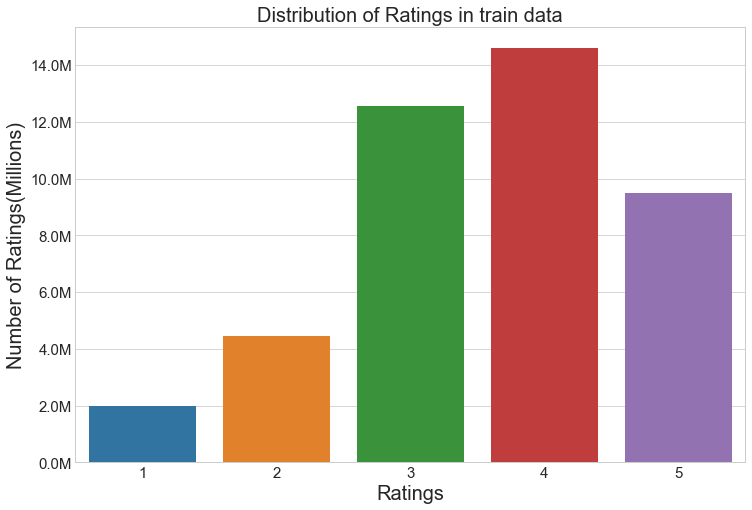

In [115]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="Ratings", data=Train_Data)

ax.set_yticklabels([changingLabels(num) for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in train data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings(Millions)", fontsize = 20)
plt.show()

In [10]:
Train_Data["DayOfWeek"] = Train_Data.Date.dt.weekday_name

In [161]:
quantiles = no_of_rated_startups_per_investor.quantile(np.arange(0,1.01,0.01))

### Analysis of Ratings Per Startup


In [234]:
no_of_ratings_per_startup = Train_Data.groupby(by = "startupID")["Ratings"].count().sort_values(ascending = False)

In [ ]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per startup", fontsize = 20)
plt.xlabel("startup", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_startup.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

## 3. Creating investor-item sparse matrix from data frame

In [3]:
startTime = datetime.now()
print("Creating investor_ITEM sparse matrix for train Data")
if os.path.isfile("../Data/TrainUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TrainUISparseData = sparse.load_npz("../Data/TrainUISparseData.npz")
    print("Shape of Train Sparse matrix = "+str(TrainUISparseData.shape))
    
else:
    print("We are creating sparse data")
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.investorID, Train_Data.startupID)))
    print("Creation done. Shape of sparse matrix = "+str(TrainUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("../Data/TrainUISparseData.npz", TrainUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for train Data
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Train Sparse matrix = (2649430, 17771)
0:00:02.746893


In [4]:
startTime = datetime.now()
print("Creating investor_ITEM sparse matrix for test Data")
if os.path.isfile("../Data/TestUISparseData.npz"):
    print("Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix")
    TestUISparseData = sparse.load_npz("../Data/TestUISparseData.npz")
    print("Shape of Test Sparse Matrix = "+str(TestUISparseData.shape))
else:
    print("We are creating sparse data")
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.investorID, Test_Data.startupID)))
    print("Creation done. Shape of sparse matrix = "+str(TestUISparseData.shape))
    print("Saving it into disk for furthur usage.")
    sparse.save_npz("../Data/TestUISparseData.npz", TestUISparseData)
    print("Done\n")

print(datetime.now() - startTime)

Creating USER_ITEM sparse matrix for test Data
Sparse Data is already present in your disk, no need to create further. Loading Sparse Matrix
Shape of Test Sparse Matrix = (2649430, 17771)
0:00:00.979906


In [26]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.90854433187319% 


In [27]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.97713608243731% 


### Finding Global average of all startup ratings, Average rating per investor, and Average rating per startup

In [5]:
def getAverageRatings(sparseMatrix, if_investor):
    ax = 1 if if_investor else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of investor if axis = 1 else 
    #sum of all the ratings of startups if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_investor else cols) if noOfRatings[i]!=0}
    return averageRatings

In [57]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.5844935859517806


In [58]:
AvgRatinginvestor = getAverageRatings(TrainUISparseData, True)

In [62]:
print("Average rating of investor 25 = {}".format(AvgRatinginvestor[25]))

Average rating of user 25 = 3.0


In [63]:
AvgRatingstartup = getAverageRatings(TrainUISparseData, False)

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('Avg Ratings per investor and per startup', fontsize=25)

investor_average = [rats for rats in AvgRatinginvestor.values()]
sns.distplot(investor_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(investor_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per investor", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

startup_average = [ratm for ratm in AvgRatingstartup.values()]
sns.distplot(startup_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(startup_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per startup", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

In [ ]:
total_investors = len(np.unique(Final_Data["investorID"]))
train_investors = len(AvgRatinginvestor)
uncommoninvestors = total_investors - train_investors
                  
print("Total number of investors = {}".format(total_investors))
print("Number of investors in train data= {}".format(train_investors))
print("Number of investors not present in train data = {}({}%)".format(uncommoninvestors, np.round((uncommoninvestors/total_investors)*100), 2))

In [ ]:
total_startups = len(np.unique(Final_Data["startupID"]))
train_startups = len(AvgRatingstartup)
uncommonstartups = total_startups - train_startups
                  
print("Total number of startups = {}".format(total_startups))
print("Number of startups in train data= {}".format(train_startups))
print("Number of startups not present in train data = {}({}%)".format(uncommonstartups, np.round((uncommonstartups/total_startups)*100), 2))

## 4. Computing Similarity Matrices

### Computing Investor-Investor Similarity Matrix

In [293]:
row_index, col_index = TrainUISparseData.nonzero()
rows = np.unique(row_index)
for i in rows[:100]:
    print(i)

6
7
10
25
33
42
59
79
83
87
94
97
131
134
142
149
158
168
169
178
183
188
189
192
195
199
201
242
247
248
261
265
266
267
268
283
291
296
298
299
301
302
304
305
307
308
310
312
314
330
331
333
352
363
368
369
379
383
384
385
392
413
416
424
437
439
440
442
453
462
470
471
477
478
479
481
485
490
491
492
495
508
515
517
527
529
536
540
544
546
550
561
576
585
592
596
602
609
614
616


In [306]:
#Here, we are calculating investor-investor similarity matrix only for first 100 investors in our sparse matrix. And we are calculating 
#top 100 most similar investors with them.
def getinvestor_investorSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()  #this will give indices of rows in "row_index" and indices of columns in 
    #"col_index" where there is a non-zero value exist.
    rows = np.unique(row_index)
    similarMatrix = np.zeros(61700).reshape(617,100)    # 617*100 = 61700. As we are building similarity matrix only 
    #for top 100 most similar investors.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} investors = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 investor = "+str(sum(timeTaken)/len(timeTaken))+"seconds")
    
    fig = plt.figure(figsize = (12,8))
    plt.plot(timeTaken, label = 'Time Taken For Each investor')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('investors', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

Computation of investor-investor similarity matrix is impossible if computational power is limited. On the other hand, if we try to reduce the dimension say by truncated SVD then it would take even more time because truncated SVD creates dense matrix and amount of multiplication for creation of investor-investor similarity matrix would increase dramatically.We maintain a binary Vector for investors, which tells us whether we already computed similarity for this investor or not.

Compute top (let's just say, 1000) most similar investors for this given investor, and add this to our datastructure, so that we can just access it(similar investors) without recomputing it again. If it is already computed. Just get it directly from our datastructure, which has that information. In production time, We might have to recompute similarities, if it is computed a long time ago. Because investors preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ). Which datastructure to use? - It is purely implementation dependant.

One simple method is to maintain a **Dictionary Of Dictionaries**.<br><br>

key    :    investorid<br>
value  :    Again a dictionary<br>
            key   : _Similar investorr<br>
            value: Similarity Value>

### Computing Startup-Startup Similarity Matrix

In [6]:
start = datetime.now()

if not os.path.isfile("../Data/m_m_similarity.npz"):
    print("startup-startup Similarity file does not exist in your disk. Creating startup-startup Similarity Matrix...")
    
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the startup Similarity matrix on disk for further usage")
    sparse.save_npz("../Data/m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz("../Data/m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    
print(datetime.now() - start)

File exists in the disk. Loading the file...
Dimension of Matrix = (17771, 17771)
0:00:09.533895


### Does Startup-Startup Similarity Work?
### Let's pick random startup and check it's top 10 investors and see if they are similar

In [46]:
startup_ids = np.unique(m_m_similarity.nonzero())

In [52]:
similar_startups_dict = dict()
for startup in startup_ids:
    smlr = np.argsort(-m_m_similarity[startup].toarray().ravel())[1:100]
    similar_startups_dict[startup] = smlr

In [54]:
startup_titles_df = pd.read_csv("../Data/startup_titles.csv",sep = ",", header = None, names=['startupID', 'Year_of_Release', 'startup_Title'], index_col = "startupID", encoding = "iso8859_2")

In [ ]:
startup_titles_df.head()

In [ ]:
startupID_GR = 17765

print("Name of the startup -------> "+str(startup_titles_df.loc[startupID_GR][1]))

print("Number of ratings by investors for startup {} is {}".format(startup_titles_df.loc[startupID_GR][1], TrainUISparseData[:,startupID_GR].getnnz()))

print("Number of similar startups to {} is {}".format(startup_titles_df.loc[startupID_GR][1], m_m_similarity[startupID_GR].count_nonzero()))

In [111]:
all_similar = sorted(m_m_similarity[startupID_GR].toarray().ravel(), reverse = True)[1:]

similar_100 = all_similar[:101]

In [ ]:
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar startups")
plt.title("Similar startups to Godzilla's Revenge", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

In [ ]:
startup_titles_df.loc[similar_startups_dict[startupID_GR][:10]]

## 5. Machine Learning Models

In [26]:
def get_sample_sparse_matrix(sparseMatrix, n_investors, n_startups):
    startTime = datetime.now()
    investors, startups, ratings = sparse.find(sparseMatrix)
    uniq_investors = np.unique(investors)
    uniq_startups = np.unique(startups)
    np.random.seed(15)   #this will give same random number everytime, without replacement
    investorS = np.random.choice(uniq_investors, n_investors, replace = False)
    startupS = np.random.choice(uniq_startups, n_startups, replace = False)
    mask = np.logical_and(np.isin(investors, investorS), np.isin(startups, startupS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (investors[mask], startups[mask])), 
                                                     shape = (max(investorS)+1, max(startupS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - start)
    return sparse_sample

### Creating Sample Sparse Matrix for Train Data

In [7]:
path = "../Data/TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Train Sample Sparse Matrix = (2649117, 17764)


### Creating Sample Sparse Matrix for Test Data

In [8]:
path = "../Data/TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Test Sample Sparse Matrix = (2647588, 17689)


### Finding Global Average of all startup ratings, Average rating per Investor, and Average rating per Startup (from sampled train)

### Finding Average of all startup ratings

### Finding Average rating per Investor


In [122]:
globalAvginvestors = getAverageRatings(train_sample_sparse, True)
print("Average investor rating for investor 16879 is {}".format(globalAvgstartups[16879]))

Average user rating for user 16879 is 3.738095238095238


### Featurizing data

In [10]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

No of ratings in Our Sampled train matrix is : 19214
No of ratings in Our Sampled test matrix is : 1150


### Featurizing data for regression problem

### Featurizing Train Data

In [210]:
sample_train_investors, sample_train_startups, sample_train_ratings = sparse.find(train_sample_sparse)

In [280]:
if os.path.isfile("../Data/Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open("../Data/Train_Regression.csv", mode = "w") as data:
        count = 0
        for investor, startup, rating in zip(sample_train_investors, sample_train_startups, sample_train_ratings):
            row = list()
            row.append(investor)  #appending investor ID
            row.append(startup) #appending startup ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "startup" by top 5 similar investors with "investor"--------------------#
            similar_investors = cosine_similarity(train_sample_sparse[investor], train_sample_sparse).ravel()
            similar_investors_indices = np.argsort(-similar_investors)[1:]
            similar_investors_ratings = train_sample_sparse[similar_investors_indices, startup].toarray().ravel()
            top_similar_investor_ratings = list(similar_investors_ratings[similar_investors_ratings != 0][:5])
            top_similar_investor_ratings.extend([globalAvgstartups[startup]]*(5-len(top_similar_investor_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "startup" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "startup" average rating.
            row.extend(top_similar_investor_ratings)
            
 #----------------------------------Ratings given by "investor" to top 5 similar startups with "startup"------------------#
            similar_startups = cosine_similarity(train_sample_sparse[:,startup].T, train_sample_sparse.T).ravel()
            similar_startups_indices = np.argsort(-similar_startups)[1:]
            similar_startups_ratings = train_sample_sparse[investor, similar_startups_indices].toarray().ravel()
            top_similar_startup_ratings = list(similar_startups_ratings[similar_startups_ratings != 0][:5])
            top_similar_startup_ratings.extend([globalAvginvestors[investor]]*(5-len(top_similar_startup_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "investor" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "investor" average rating.
            row.extend(top_similar_startup_ratings)
            
 #----------------------------------Appending "investor" average, "startup" average & rating of "investor""startup"-----------#
            row.append(globalAvginvestors[investor])
            row.append(globalAvgstartups[startup])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

Preparing Train csv file for 19214 rows
Done for 2000. Time elapsed: 0:14:17.429226
Done for 4000. Time elapsed: 0:25:51.882984
Done for 6000. Time elapsed: 0:37:21.039996
Done for 8000. Time elapsed: 0:49:03.121577
Done for 10000. Time elapsed: 1:00:25.030957
Done for 12000. Time elapsed: 1:11:50.660054
Done for 14000. Time elapsed: 1:24:15.366893
Done for 16000. Time elapsed: 1:36:31.156832
Done for 18000. Time elapsed: 1:48:18.891065
Total Time for 19214 rows = 1:55:33.782934


In [ ]:
Train_Reg = pd.read_csv("../Data/Train_Regression.csv", names = ["investor_ID", "startup_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "investor_Average", "startup_Average", "Rating"])
Train_Reg.head()

In [3]:
print("Number of nan Values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan Values = 0


<p><b>Investor_ID:</b> ID of a this Investor</p>

<p><b>Startup_ID:</b> ID of a this Startup</p>

<p><b>Global_Average:</b> Global Average Rating</p>

<p><b>Ratings given to this Startup by top 5 similar investors with this Investor:</b> (SUR1, SUR2, SUR3, SUR4, SUR5)</p>
   
<p><b>Ratings given by this Investor to top 5 similar startups with this Startup:</b> (SMR1, SMR2, SMR3, SMR4, SMR5)</p>

<p><b>Investor_Average:</b> Average Rating of this Investor</p>

<p><b>Startup_Average:</b> Average Rating of this Startup</p>

<p><b>Rating:</b> Rating given by this Investor to this Startup</p>

In [4]:
print("Shape of Train DataFrame = {}".format(Train_Reg.shape))

Shape of Train DataFrame = (19214, 16)


### Featurizing Test Data

In [274]:
sample_test_investors, sample_test_startups, sample_test_ratings = sparse.find(test_sample_sparse)

In [275]:
if os.path.isfile("../Data/Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open("../Data/Test_Regression.csv", mode = "w") as data:
        count = 0
        for investor, startup, rating in zip(sample_test_investors, sample_test_startups, sample_test_ratings):
            row = list()
            row.append(investor)  #appending investor ID
            row.append(startup) #appending startup ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#-----------------------------Ratings given to "startup" by top 5 similar investors with "investor"-------------------------#
            try:
                similar_investors = cosine_similarity(train_sample_sparse[investor], train_sample_sparse).ravel()
                similar_investors_indices = np.argsort(-similar_investors)[1:]
                similar_investors_ratings = train_sample_sparse[similar_investors_indices, startup].toarray().ravel()
                top_similar_investor_ratings = list(similar_investors_ratings[similar_investors_ratings != 0][:5])
                top_similar_investor_ratings.extend([globalAvgstartups[startup]]*(5-len(top_similar_investor_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "startup" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "startup" average rating.
                row.extend(top_similar_investor_ratings)
            #########Cold Start Problem, for a new investor or a new startup#########    
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Ratings given by "investor" to top 5 similar startups with "startup"-----------------------#
            try:
                similar_startups = cosine_similarity(train_sample_sparse[:,startup].T, train_sample_sparse.T).ravel()
                similar_startups_indices = np.argsort(-similar_startups)[1:]
                similar_startups_ratings = train_sample_sparse[investor, similar_startups_indices].toarray().ravel()
                top_similar_startup_ratings = list(similar_startups_ratings[similar_startups_ratings != 0][:5])
                top_similar_startup_ratings.extend([globalAvginvestors[investor]]*(5-len(top_similar_startup_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "investor" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "investor" average rating.
                row.extend(top_similar_startup_ratings)
            #########Cold Start Problem, for a new investor or a new startup#########
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Appending "investor" average, "startup" average & rating of "investor""startup"----------------#
            try:        
                row.append(globalAvginvestors[investor])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(globalAvgstartups[startup])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#------------------------------Converting rows and appending them as comma separated values to csv file-----------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

Preparing Test csv file for 1150 rows
Done for 100. Time elapsed: 0:00:57.690535
Done for 200. Time elapsed: 0:01:55.658291
Done for 300. Time elapsed: 0:02:51.644355
Done for 400. Time elapsed: 0:03:48.542774
Done for 500. Time elapsed: 0:04:46.203274
Done for 600. Time elapsed: 0:05:43.748850
Done for 700. Time elapsed: 0:06:40.060096
Done for 800. Time elapsed: 0:07:36.876978
Done for 900. Time elapsed: 0:08:35.474421
Done for 1000. Time elapsed: 0:09:35.487426
Done for 1100. Time elapsed: 0:10:33.057698
Total Time for 1150 rows = 0:11:01.636286


In [ ]:
Test_Reg = pd.read_csv("../Data/Test_Regression.csv", names = ["investor_ID", "startup_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "investor_Average", "startup_Average", "Rating"])
Test_Reg.head()

In [6]:
print("Number of nan Values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan Values = 0


In [7]:
print("Shape of Test DataFrame = {}".format(Test_Reg.shape))

Shape of Test DataFrame = (1150, 16)


### Transforming Data for Surprise Models

#### Transforming Train Data

- We can't give raw data to train the model in Surprise library.


- They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [ ]:
Train_Reg[['investor_ID', 'startup_ID', 'Rating']].head(5)

In [9]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(Train_Reg[['investor_ID', 'startup_ID', 'Rating']], reader)

trainset = data.build_full_trainset()

#### Transforming Test Data

- For test data we just have to define a tuple (investor, item, rating).
- You can check out this link: https://github.com/NicolasHug/Surprise/commit/86cf44529ca0bbb97759b81d1716ff547b950812
- Above link is a github of surprise library. Check methods "def all_ratings(self)" and "def build_testset(self)" from line
  177 to 201(If they modify the file then line number may differ, but you can always check aforementioned two methods).
- "def build_testset(self)" method returns a list of tuples of (investor, item, rating).

In [10]:
testset = list(zip(Test_Reg["investor_ID"].values, Test_Reg["startup_ID"].values, Test_Reg["Rating"].values))

In [11]:
testset[:5]

[(464626, 4614, 3),
 (1815614, 4627, 3),
 (2298717, 4627, 5),
 (2532402, 4627, 4),
 (2027, 4798, 5)]

### Applying Machine Learning Models

<p>We have two Error Metrics.</p>
<p><b>->   RMSE: Root Mean Square Error: </b>RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.</p>
<p><b>->   MAPE: Mean Absolute Percentage Error: </b>The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.</p>
<p>where At is the actual value and Ft is the forecast value.</p>
<p>
The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.</p>

<b>We can also use other regression models. But  we are using exclusively XGBoost as it is typically fairly powerful in practice.</b>

In [12]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [13]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

### Utility Functions for Regression Models

In [14]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [15]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

In [16]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

### Utility Functions for Surprise Models

In [17]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted
#in surprise prediction of every data point is returned as dictionary like this:
#"investor: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating 

In [18]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [19]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    #You can check out above function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    #You can check out "trainset.build_testset()" function at "https://surprise.readthedocs.io/en/stable/FAQ.html#can-i-use-my-own-dataset-with-surprise-and-can-it-be-a-pandas-dataframe" in 
    #"How to get accuracy measures on the training set" section
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

## Surprise BaselineOnly Model

### Predicted Rating
> $\large\hat{r}_{ui} = \mu + b_u + b_i$<br><br>

- $\mu$: Average Global Ratings in training data<br>
- $b_u$: User-Bias<br>
- $b_i$: Item-Bias

### Optimization Function
> $\large \sum_{r_ui \in R_{Train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right). \left[minimize\; b_u, b_i \right]$

In [22]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)
#You can check the docs of above used functions at:https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#at section "Baselines estimates configuration".

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8811426214928658
MAPE = 27.158727146074078
--------------------------------------------------
TEST DATA
RMSE = 1.0678388468431512
MAPE = 33.39729060309592
--------------------------------------------------
Time Taken = 0:00:00.516484


##

## XGBoost 13 Features + Surprise BaselineOnly Model

### Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

In [23]:
Train_Reg["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]

In [25]:
print("Number of nan values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan values = 0


In [27]:
print("Number of nan values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan values = 0


## 4. Surprise KNN-Baseline with Investor-Invesor and Item-Item Similarity

### Prediction $\hat{r}_{ui}$ in case of investor-investor similarity

$\large \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v
\in N^k_i(u)} \text{sim}(u, v)}$

- $\pmb{b_{ui}}$ - Baseline prediction_ of (investor, startup) rating which is "$b_{ui} = \mu + b_u + b_i$".

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ investors (neighbours) of __investor(u)__ who rated __startup(i)__  

- _sim (u, v)_ - Similarity between investors __u and v__ who also rated startup 'i'. This is exactly same as our hand-crafted features 'SUR'- 'Similar Investor Rating'. Means here we have taken 'k' such similar investors 'v' with investor 'u' who also rated startup 'i'. $r_{vi}$ is the rating which investor 'v' gives on item 'i'. $b_{vi}$ is the predicted baseline model rating of investor 'v' on item 'i'.
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take - base line predictions instead of mean rating of investor/item)<br><br><br><br>  

### Prediction $\hat{r}_{ui}$ in case of item-item similarity

$\large \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in
N^k_u(j)} \text{sim}(i, j)}$

- __Notation is same as of investor-investor similarity__<br><br><br>


#### Documentation you can check at:
KNN BASELINE: https://surprise.readthedocs.io/en/stable/knn_inspired.html

PEARSON_BASELINE SIMILARITY: http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline

SHRINKAGE: Neighborhood Models in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

### 4.1 Surprise KNN-Baseline with investor-investor.

#### Cross- Validation

In [56]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "investor_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

### Applying KNNBaseline investor-investor with best parameters

In [61]:
sim_options = {'name':'pearson_baseline', 'investor_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_investor")

model_train_evaluation["KNNBaseline_investor"] = train_result
model_test_evaluation["KNNBaseline_investor"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.3044975188091617
MAPE = 8.090955152033715
--------------------------------------------------
TEST DATA
RMSE = 1.067654798722828
MAPE = 33.39814334762251
--------------------------------------------------
Time Taken = 0:00:13.622646


### 2 Surprise KNN-Baseline with Item-Item.

#### Cross- Validation

In [62]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "investor_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

#### Applying KNNBaseline Item-Item with best parameters

In [65]:
sim_options = {'name':'pearson_baseline', 'investor_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.1818822561823507
MAPE = 4.2501507953116135
--------------------------------------------------
TEST DATA
RMSE = 1.067654798722828
MAPE = 33.39814334762251
--------------------------------------------------
Time Taken = 0:00:00.914647


## XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline

### Adding predicted ratings from Surprise KNN Baseline model to our Train and Test Dataframe

In [68]:
Train_Reg["KNNBaseline_investor"] = model_train_evaluation["KNNBaseline_investor"]["Prediction"]
Train_Reg["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

Test_Reg["KNNBaseline_investor"] = model_test_evaluation["KNNBaseline_investor"]["Prediction"]
Test_Reg["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [72]:
print("Number of nan values in Train Data "+str(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data 0


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Investor_ID</th>
      <th>Startup_ID</th>
      <th>Global_Average</th>
      <th>SUR1</th>
      <th>SUR2</th>
      <th>SUR3</th>
      <th>SUR4</th>
      <th>SUR5</th>
      <th>SMR1</th>
      <th>SMR2</th>
      <th>SMR3</th>
      <th>SMR4</th>
      <th>SMR5</th>
      <th>Investor_Average</th>
      <th>Startup_Average</th>
      <th>Rating</th>
      <th>BaselineOnly</th>
      <th>KNNBaseline_User</th>
      <th>KNNBaseline_Item</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>180921</td>
      <td>4512</td>
      <td>3.582804</td>
      <td>3.0</td>
      <td>2.0</td>
      <td>1.0</td>
      <td>2.0</td>
      <td>1.0</td>
      <td>4.0</td>
      <td>3.0</td>
      <td>4.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>2.900000</td>
      <td>2.5</td>
      <td>1</td>
      <td>2.077166</td>
      <td>1.193482</td>
      <td>1.076235</td>
    </tr>
    <tr>
      <th>1</th>
      <td>210185</td>
      <td>4512</td>
      <td>3.582804</td>
      <td>2.0</td>
      <td>1.0</td>
      <td>3.0</td>
      <td>3.0</td>
      <td>4.0</td>
      <td>3.0</td>
      <td>3.0</td>
      <td>3.0</td>
      <td>4.0</td>
      <td>4.0</td>
      <td>3.388889</td>
      <td>2.5</td>
      <td>2</td>
      <td>2.916411</td>
      <td>2.246199</td>
      <td>2.014904</td>
    </tr>
    <tr>
      <th>2</th>
      <td>218038</td>
      <td>4512</td>
      <td>3.582804</td>
      <td>2.0</td>
      <td>3.0</td>
      <td>3.0</td>
      <td>2.0</td>
      <td>4.0</td>
      <td>4.0</td>
      <td>4.0</td>
      <td>4.0</td>
      <td>3.0</td>
      <td>5.0</td>
      <td>4.250000</td>
      <td>2.5</td>
      <td>4</td>
      <td>2.905264</td>
      <td>3.727792</td>
      <td>3.653776</td>
    </tr>
    <tr>
      <th>3</th>
      <td>221936</td>
      <td>4512</td>
      <td>3.582804</td>
      <td>4.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>1.0</td>
      <td>2.0</td>
      <td>3.0</td>
      <td>4.0</td>
      <td>4.0</td>
      <td>5.0</td>
      <td>3.0</td>
      <td>3.458333</td>
      <td>2.5</td>
      <td>3</td>
      <td>3.290933</td>
      <td>3.097569</td>
      <td>2.961074</td>
    </tr>
    <tr>
      <th>4</th>
      <td>370736</td>
      <td>4512</td>
      <td>3.582804</td>
      <td>2.0</td>
      <td>4.0</td>
      <td>1.0</td>
      <td>2.0</td>
      <td>2.0</td>
      <td>4.0</td>
      <td>4.0</td>
      <td>4.0</td>
      <td>4.0</td>
      <td>5.0</td>
      <td>4.038462</td>
      <td>2.5</td>
      <td>4</td>
      <td>3.561135</td>
      <td>3.042586</td>
      <td>3.105870</td>
    </tr>
  </tbody>
</table>
</div>

In [74]:
print("Number of nan values in Test Data "+str(Test_Reg.isnull().sum().sum()))

Number of nan values in Test Data 0


## Matrix Factorization SVD 

#### Prediction $\hat{r}_{ui}$ is set as:<br>

$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$
- $\pmb q_i$ - Representation of item in latent factor space
        
- $\pmb p_u$ - Representation of investor in new latent factor space<br>

__If investor u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$ and $q_i$.__<br><br><br>


#### Optimization Problem<br>

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) \left[minimize\; b_u, b_i, q_i, p_u \right]$
<br><br><br>

SVD Documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

#### Cross- Validation

In [90]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   #here, n_factors is the equivalent to dimension 'd' when matrix 'A'
#is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9917179812600221
{'n_factors': 5}


### Applying SVD with best parameters

In [91]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8914245646368677
MAPE = 27.90407603935644
--------------------------------------------------
TEST DATA
RMSE = 1.0676670421292496
MAPE = 33.39888276741577
--------------------------------------------------
Time Taken = 0:00:00.716508


## Matrix Factorization SVDpp with implicit feedback

#### Prediction $\hat{r}_{ui}$ is set as:<br>
$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)$<br><br>

 - $ \pmb{I_u}$ --- the set of all items rated by investor u. $|I_u|$ is a length of that set.<br>

-  $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings. Here, an implicit rating describes the fact that a investoru rated an item j, regardless of the rating value. $y_i$ is an item vector. For every item j, there is an item vector $y_j$ which is an implicit feedback. Implicit feedback indirectly reflects opinion by observing investor behavior including purchase history, browsing history, search patterns, or even mouse movements. Implicit feedback usually denotes the presence or absence of an event. For example, there is a startup 10 where investor has just checked the details of the startup and spend some time there, will contribute to implicit rating. <br><br>

__If investor u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$, $q_i$ and $y_i$.__<br><br><br>

#### Optimization Problem

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right).\left[minimize\; b_u, b_i, q_i, p_u, y_j \right]$<br><br>

SVDpp Documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

#### Cross- Validation

In [109]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9912340650066573
{'n_factors': 10, 'lr_all': 0.006}


#### Applying SVDpp with best parameters

In [111]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.7891759935507388
MAPE = 24.165955103679742
--------------------------------------------------
TEST DATA
RMSE = 1.0675830366748182
MAPE = 33.396452697149705
--------------------------------------------------
Time Taken = 0:00:07.075453


## XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

In [112]:
Train_Reg["SVD"] = model_train_evaluation["SVD"]["Prediction"]
Train_Reg["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

Test_Reg["SVD"] = model_test_evaluation["SVD"]["Prediction"]
Test_Reg["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [114]:
print("Number of nan values in Train Data "+str(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data 0


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Investor_ID</th>
      <th>Startup_ID</th>
      <th>Global_Average</th>
      <th>SUR1</th>
      <th>SUR2</th>
      <th>SUR3</th>
      <th>SUR4</th>
      <th>SUR5</th>
      <th>SMR1</th>
      <th>SMR2</th>
      <th>...</th>
      <th>SMR4</th>
      <th>SMR5</th>
      <th>Investor_Average</th>
      <th>Startup_Average</th>
      <th>Rating</th>
      <th>BaselineOnly</th>
      <th>KNNBaseline_User</th>
      <th>KNNBaseline_Item</th>
      <th>SVD</th>
      <th>SVDpp</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>464626</td>
      <td>4614</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>...</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
    </tr>
    <tr>
      <th>1</th>
      <td>1815614</td>
      <td>4627</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>...</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
    </tr>
    <tr>
      <th>2</th>
      <td>2298717</td>
      <td>4627</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>...</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>5</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
    </tr>
    <tr>
      <th>3</th>
      <td>2532402</td>
      <td>4627</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>...</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>4</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
    </tr>
    <tr>
      <th>4</th>
      <td>2027</td>
      <td>4798</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>...</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>5</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
      <td>3.582804</td>
    </tr>
  </tbody>
</table>
<p>5 rows × 21 columns</p>
</div>

In [116]:
print("Number of nan values in Test Data "+str(Test_Reg.isnull().sum().sum()))

Number of nan values in Test Data 0


## Surprise KNN Baseline + SVD + SVDpp

--------------------------------------------------
TRAIN DATA
RMSE = 1.072048298658654
MAPE = 35.50347089767456
--------------------------------------------------
TEST DATA
RMSE = 1.0704493877647514
MAPE = 33.36904800491091
--------------------------------------------------
Time Taken = 0:00:00.595421


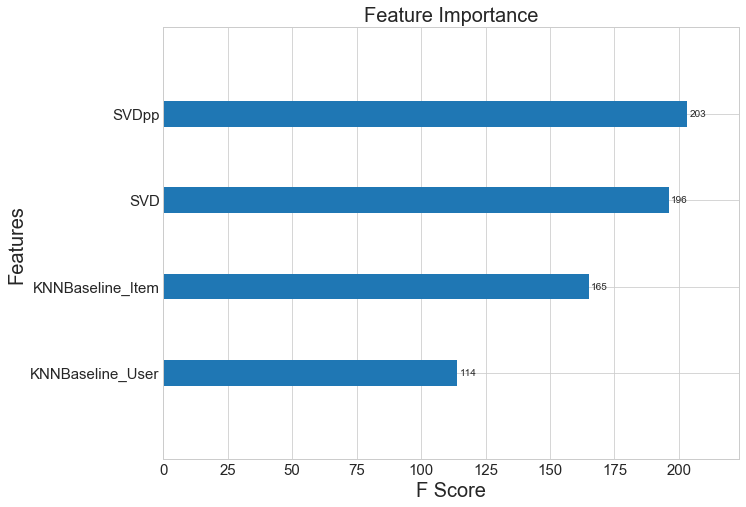

In [122]:
x_train = Train_Reg[["KNNBaseline_investor", "KNNBaseline_Item", "SVD", "SVDpp"]]

x_test = Test_Reg[["KNNBaseline_investor", "KNNBaseline_Item", "SVD", "SVDpp"]]

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF")

model_train_evaluation["XGB_KNN_MF"] = train_result
model_test_evaluation["XGB_KNN_MF"] = test_result

## Summary

In [125]:
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

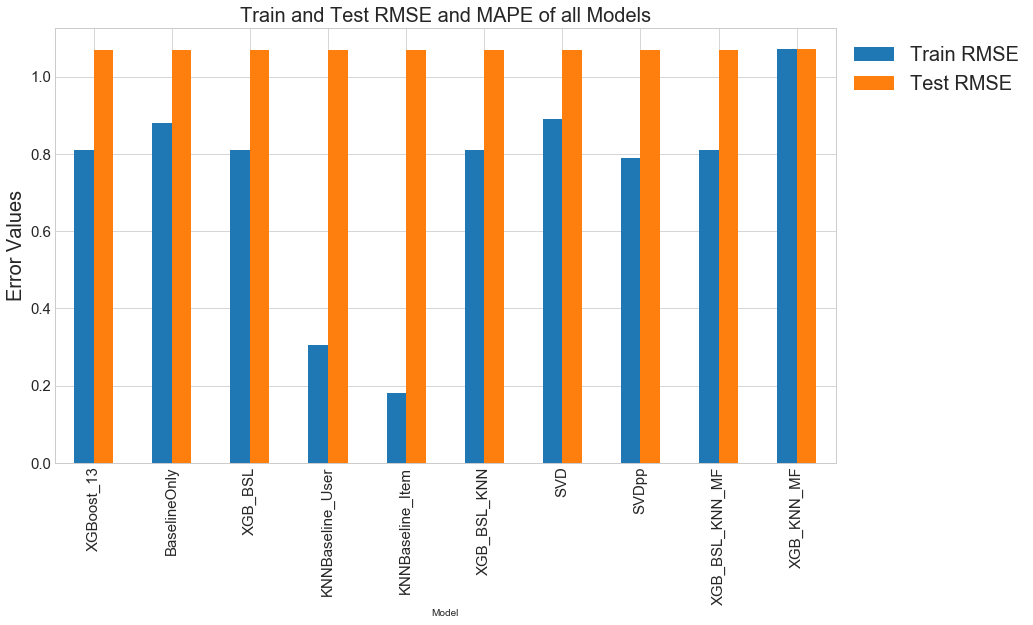

In [140]:
error_table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [151]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1).style.highlight_min(axis=0)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.810186,1.06861
1,BaselineOnly,0.881143,1.06784
2,XGB_BSL,0.809892,1.06768
3,KNNBaseline_User,0.304498,1.06765
4,KNNBaseline_Item,0.181882,1.06765
5,XGB_BSL_KNN,0.810548,1.06928
6,SVD,0.891425,1.06767
7,SVDpp,0.789176,1.06758
8,XGB_BSL_KNN_MF,0.809967,1.06943
9,XGB_KNN_MF,1.07205,1.07045


# So, far our best model is SVDpp with Test RMSE of 1.067583

<p> To conclude this model is working as expected and will be used for the reccomendation model for Seedswipe. I encourage you to test the model on different datasets and make improvements to the model. If you want to reproduce the results the Crunchbase API can be found at: https://data.crunchbase.com/docs/using-the-api </p>